In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tslearn as ts
import numpy as np

# 1. Import et nettoyage des données

In [25]:
house1_power_blk2 = pd.read_csv('data/house1_power_blk2_labels.zip', index_col='datetime').interpolate('linear')
house1_power_blk2.index = pd.to_datetime(house1_power_blk2.index)
house1_power_blk2 = house1_power_blk2.asfreq('s')
#house1_power_blk2 = house1_power_blk2.loc['2016-03-06 00:00:00':'2016-04-06 00:00:00']
#house1_power_blk2 = house1_power_blk2.resample('1min').nearest()
house1_power_blk2.head()

,mains,activity
datetime,,
2016-03-06 00:00:00,473.0,0
2016-03-06 00:00:01,474.0,0
2016-03-06 00:00:02,476.0,0
2016-03-06 00:00:03,476.0,0
2016-03-06 00:00:04,475.0,0


In [27]:
from sklearn.preprocessing import MinMaxScaler

house1_power_blk2['mains_scaled'] = MinMaxScaler().fit_transform(house1_power_blk2['mains'].values.reshape(-1,1))
house1_power_blk2['diff_scaled'] = MinMaxScaler().fit_transform(house1_power_blk2['mains'].diff(1).values.reshape(-1,1))
#house1_power_blk2['diff_1d_scaled'] = MinMaxScaler().fit_transform(house1_power_blk2['mains'].diff(int(60*60*24)).values.reshape(-1,1))
house1_power_blk2 = house1_power_blk2.dropna()

In [28]:
def split_train_test_indexes(data, percentage=0.3):
    # tirage de jours aléatoires
    delta_time = data.index[-2] - data.index[0]
    nb_days = int(delta_time.days * percentage)
    random_dates = house1_power_blk2.index[0] + pd.to_timedelta(np.random.choice(delta_time.days, nb_days, replace=False), unit='day')

    data_freq = pd.Timedelta(house1_power_blk2.index.freq).seconds if house1_power_blk2.index.freq else 1
    # définition des indexes test, train
    test_indexes = pd.DatetimeIndex(np.array([pd.date_range(d, periods=24*60*60/data_freq, freq=house1_power_blk2.index.freq) for d in random_dates]).ravel())
    train_indexes = data.index[~np.isin(data.index, test_indexes)]

    return train_indexes, test_indexes

In [29]:
train_indexes, test_indexes = split_train_test_indexes(house1_power_blk2, 0.3)
X_train, X_test = house1_power_blk2.loc[train_indexes, ['mains_scaled', 'diff_scaled', 'diff_1d_scaled']].values, house1_power_blk2.loc[test_indexes, ['mains_scaled', 'diff_scaled', 'diff_1d_scaled']].values
y_train, y_test = house1_power_blk2.loc[train_indexes, 'activity'].values, house1_power_blk2.loc[test_indexes, 'activity'].values

# 2. Algorithmes généraux

In [30]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import fbeta_score, accuracy_score

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train.ravel())
y_pred = knn.predict(X_test)
print(fbeta_score(y_test, y_pred, average='macro', beta=0.5))
print(accuracy_score(y_test, y_pred))

0.7052734272235739
0.7309098508230453


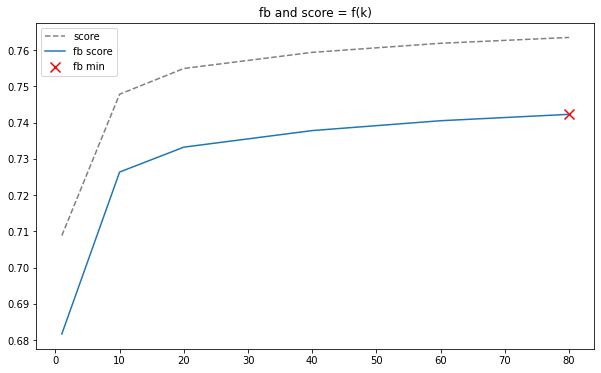

Meilleur fb score=0.74 obtenu pour b=80.00


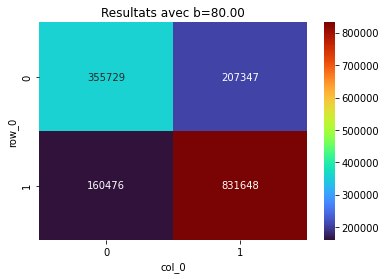

In [31]:
scores = []
fb_scores = []
k_range = [1, 10, 20, 40, 60, 80]
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train.ravel())
    y_pred = knn.predict(X_test)
    fb_scores.append(fbeta_score(y_test, y_pred, average='macro', beta=0.5))
    scores.append(accuracy_score(y_test, y_pred))

best_param = np.argmax(fb_scores)

plt.figure(figsize=(10, 6));
plt.plot(k_range, scores, label='score', color='grey', linestyle='dashed');
plt.plot(k_range, fb_scores, label='fb score');
plt.scatter(k_range[best_param], fb_scores[best_param], label='fb min', marker='x', s=100, color='red')
plt.legend();
plt.title('fb and score = f(k)');
plt.show();

print('Meilleur fb score={:.2f} obtenu pour b={:.2f}'.format(fb_scores[best_param], k_range[best_param]))

sns.heatmap(pd.crosstab(y_test, y_pred), annot=True, fmt='d', cmap='turbo');
plt.title('Resultats avec b={:.2f}'.format(k_range[best_param]));
plt.show();


# 3. Algorithmes sur Time Series

In [34]:
from tslearn.utils import to_time_series
from tslearn.preprocessing import TimeSeriesScalerMinMax

X_train, X_test = to_time_series(house1_power_blk2.loc[train_indexes, 'mains']), to_time_series(house1_power_blk2.loc[test_indexes, 'mains'])
y_train, y_test = house1_power_blk2.loc[train_indexes, 'activity'].values, house1_power_blk2.loc[test_indexes, 'activity'].values

scaler = TimeSeriesScalerMinMax()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
from tslearn.neighbors import KNeighborsTimeSeriesClassifier
from sklearn.metrics import fbeta_score, accuracy_score

knn = KNeighborsTimeSeriesClassifier(n_neighbors=3)
knn.fit(X_train, y_train.ravel())
y_pred = knn.predict(X_test)
print(fbeta_score(y_test, y_pred, average='macro', beta=0.5))
print(accuracy_score(y_test, y_pred))

KeyboardInterrupt: 

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from dtw import dtw

def dtw_dist(x,y):
    d = dtw(x, y)
    return d.distance

knn = KNeighborsClassifier(n_neighbors=3, metric=dtw_dist)
knn.fit(X_train.ravel().reshape((-1,1)), y_train.round().ravel())
knn.score(X_test.ravel().reshape((-1,1)), y_test.round().ravel())